# Learning accelerometer data using autoencoders, classification, and K-means

we will use the same approach too all 3 and see the difference. We will have a couple of steps we need to follow.

- **Data Collection**:
Gather raw accelerometer data, which typically includes readings for the x, y, and z axes.
- **Data Cleaning**:
Handle any missing values, outliers, or noise in the data.
- **Feature Extraction/Engineering**:
Extract relevant features from the raw accelerometer readings. This could include metrics like mean, standard deviation, variance, skewness, kurtosis, and other statistical measures for each axis. Additionally, you might calculate features related to signal frequency, such as Fast Fourier Transform (FFT) coefficients or spectral entropy.
- **Normalization**:
Normalize the features, typically within each axis. Since accelerometer data usually have different ranges and units for each axis, you'll want to apply normalization to ensure that all features have similar scales. Techniques like z-score standardization or min-max scaling can be used.
- **Training the model**:
- **Deploying the model**:

In [1]:
#Get the necessary packages (importing libraries and dependecies)
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
import tensorflow as tf
from scipy import stats

#set the threshhold of prinitng data to console to maximum value
#so avoid the loss of data on console while displaying
np.set_printoptions(threshold=sys.maxsize)
# setting up a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

## Data Collection

Ensure that the data collected is representative of the actual conditions the machinery will face. This will help in training a robust model.

- collecting from amplifier (Hz + vol + timestamp)
- loading data
- inspecting data (plotting - 2D and/or 3D in this case)
- labelling data (if necessary)

Data Augmentation: Depending on the availability of labeled data, consider techniques like data augmentation to increase the diversity of your training set.

### Collecting data from amplifier

Already done through the help of the arduino nano 33 ble sense, using the IMU sensor taking only the acceleromenter data (x,y,z), uploading it through the CoolTerm application. The dataset has 60hz and 30 volume was made using an amplifier taped on a wooden board (same for the microcontroller) with the use of the website https://www.szynalski.com/tone-generator/

### Loading the data

You will have to manually upload the .txt files in colab (for now) in order to get access to the raw data.

We will define a function **readData()** to get access in the .txt files and also give names to the columns.

In [2]:
# defining function for loading the dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['x-axis','y-axis','z-axis']
    #read the specified file using pandas function and return the data
    data = pd.read_csv(filePath, header=None, names=columnNames, sep='\t', na_values=';')
    return data

In [3]:
# Read The Normal Data (data in which machinery runs normally)
capture = "1"
hertz = "60"
volume = "30"
filename = "capture" + capture + "_" + hertz + "hz_" + volume + "vol.txt"
normal_data = readData(filename)

# Add a new column for sequential timestamps
normal_data['timestamp'] = np.arange(1, len(normal_data) + 1)

normal_data

x-axis  y-axis  z-axis  timestamp
0        0.03   -0.07    0.70          1
1       -0.10    0.04    1.20          2
2        0.03   -0.07    0.71          3
3       -0.10    0.04    1.20          4
4        0.03   -0.07    0.71          5
...       ...     ...     ...        ...
36309   -0.01   -0.01    0.96      36310
36310   -0.00    0.01    1.14      36311
36311   -0.01   -0.01    0.97      36312
36312   -0.00    0.01    1.14      36313
36313   -0.01   -0.01    0.98      36314

[36314 rows x 4 columns]

In [4]:
# Read The Anomalous Data (data in which machinery doesn't run normally)
capture = "3"
hertz = "80"
volume = "20"
filename = "capture" + capture + "_" + hertz + "HZ_" + volume + "vol.txt"
anomalous_data = readData(filename)

# Add a new column for sequential timestamps
anomalous_data['timestamp'] = np.arange(1, len(anomalous_data) + 1)

anomalous_data

x-axis  y-axis  z-axis  timestamp
0       -0.16    0.14    1.14          1
1        0.23   -0.17    1.31          2
2       -0.07    0.03    0.55          3
3       -0.16    0.14    1.15          4
4        0.23   -0.18    1.30          5
...       ...     ...     ...        ...
36207   -0.22    0.15    0.63      36208
36208    0.03   -0.00    1.43      36209
36209    0.20   -0.16    0.93      36210
36210   -0.22    0.15    0.64      36211
36211    0.03   -0.01    1.43      36212

[36212 rows x 4 columns]

### Inspecting the data

A very crucial step at the beginning of any ML project is becoming one with the data. So we saw that the data was properly place in the *dataset* variable. Now, in order to have a better visualization of the data we will plot it.

It's important to inspect the data to ensure it looks reasonable and that there are no obvious outliers or artifacts.

#### Plotting 2D

In [5]:
# defining the function to plot a single axis data
# setup color, title, limit and add grid.
def plotAxis(axis, x, y, title):
    axis.plot(x, y, color='green', linewidth=1)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y), max(y)+np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

# defining a function to plot the data for a given vibration pattern
def plotVibPattern(data, hz, vol):
    # make subplots of x, y, z over timestamp
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
    plotAxis(ax0, data['timestamp'], data['x-axis'], 'X-AXIS')
    plotAxis(ax1, data['timestamp'], data['y-axis'], 'Y-AXIS')
    plotAxis(ax2, data['timestamp'], data['z-axis'], 'Z-AXIS')
    # set the size and title
    plt.subplots_adjust(hspace=0.2)
    title = "Accelerometer data for " + hz + "HZ and " + vol + " volume"
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

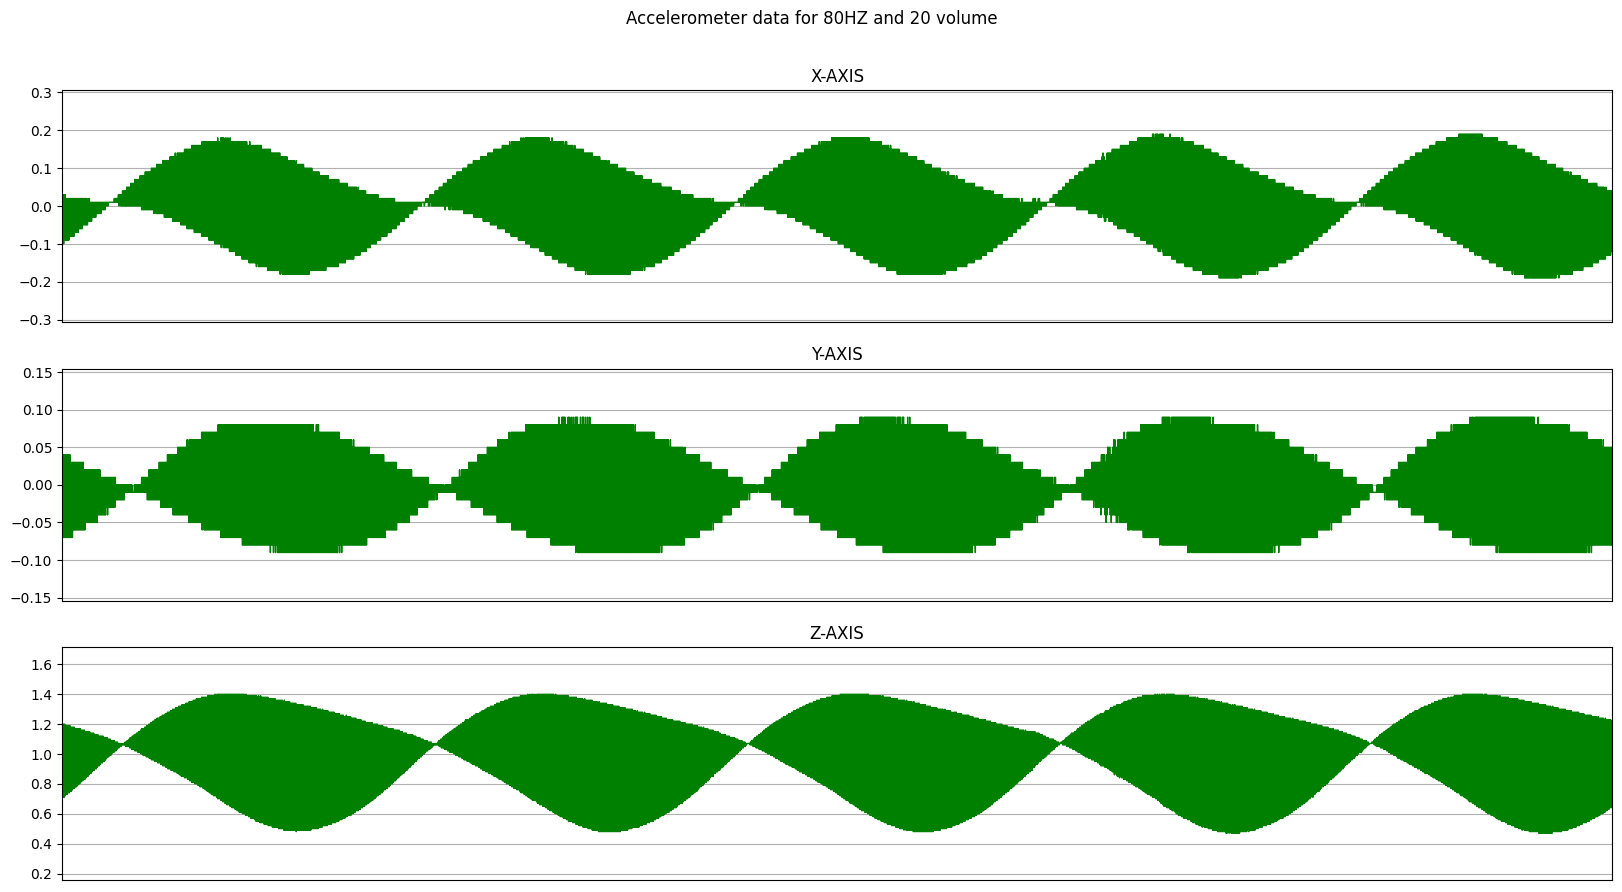

In [6]:
#select a subset of 2000 samples
subset = normal_data[:3000]
plotVibPattern(subset, hertz, volume)

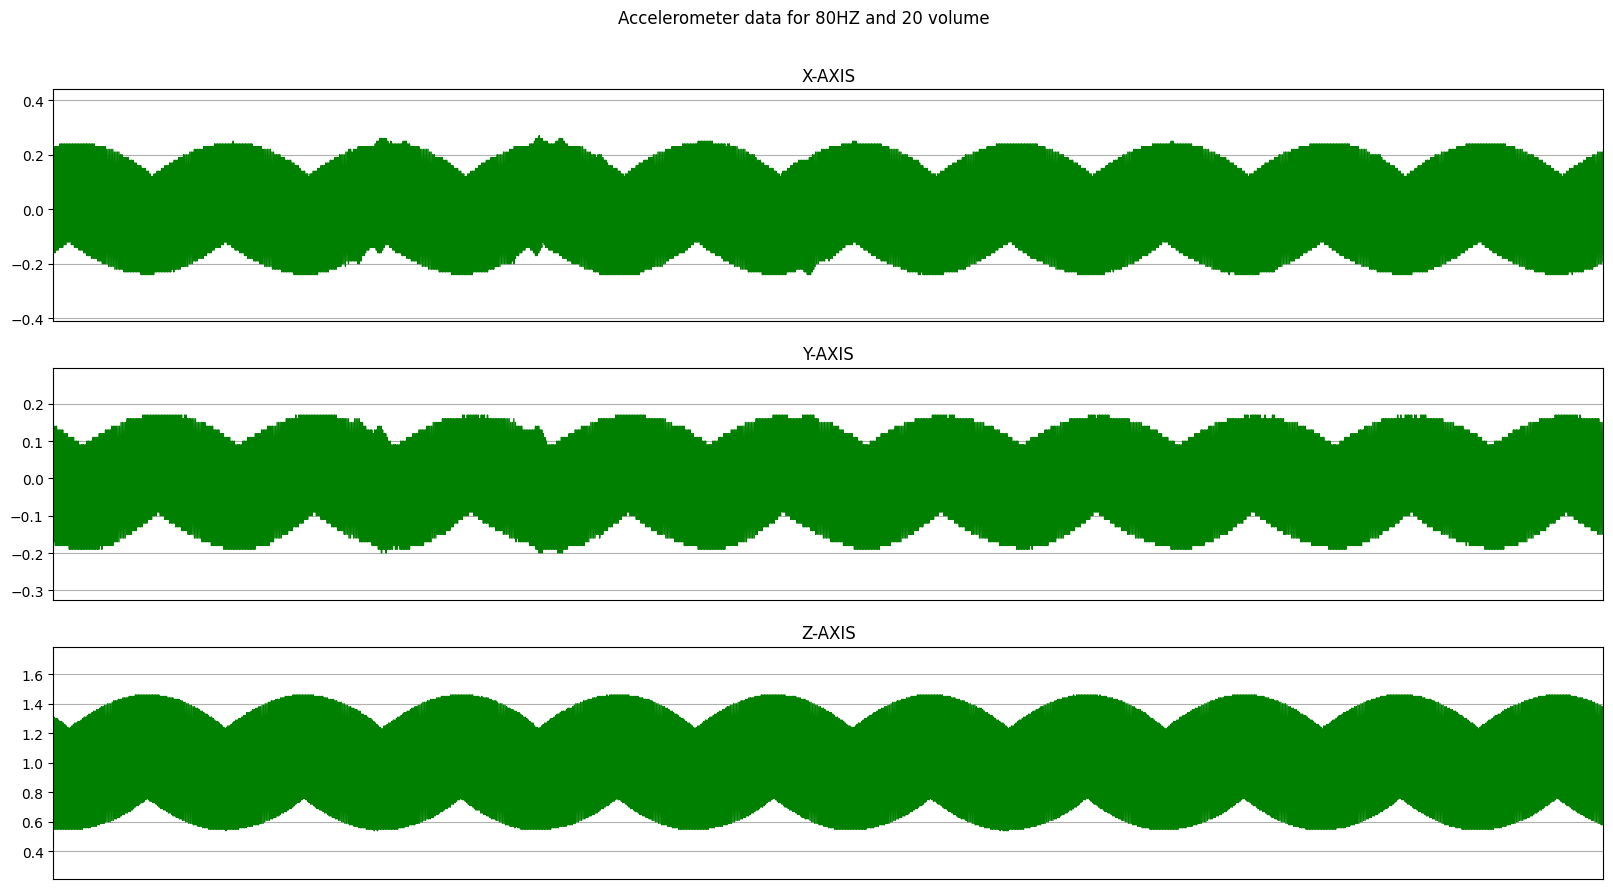

In [7]:
#select a subset of 2000 samples
subset = anomalous_data[:3000]
plotVibPattern(subset, hertz, volume)

#### Plotting 3D

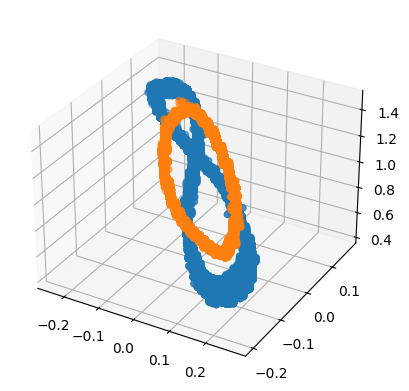

In [8]:
from mpl_toolkits import mplot3d
# to use interactive figures, you can use %matplotlib notebook rather than %matplotlib inline when running this code.
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(normal_data['x-axis'], normal_data['y-axis'], normal_data['z-axis'], 'red')
#ax.plot3D(anomalous_data['x-axis'], anomalous_data['y-axis'], anomalous_data['z-axis'], 'green')
ax.scatter3D(normal_data['x-axis'], normal_data['y-axis'], normal_data['z-axis']);
ax.scatter3D(anomalous_data['x-axis'], anomalous_data['y-axis'], anomalous_data['z-axis']);

Some conclusions:

**No Obvious Outliers**: This is a positive sign. Small deviations that aren't significant can often be handled by the model and it can contribute to the model's generalizability.

**Overlapping Data**: The fact that some data points from the normal and anomalous datasets overlap in the 3D plot is an interesting observation. This might make clustering more challenging, but it's not necessarily a problem. It could indicate that some patterns are similar between normal and anomalous data.

**Shapes in 3D Plot**: The 8-shape created by the normal data and the 0-shape created by the anomalous data provide visual representations of the patterns. Understanding these shapes can potentially guide the feature extraction and model selection.

In [9]:
# Pick a random row from the dataset
random_reading = normal_data.sample(n=1)

# our data is actually giant arrays/tensors
#ternsors are inputs to our neural networks
tf.constant(random_reading)

#you can also see the entire dataset as tensors (it'll take a bit longer to compute)
#using this command: tf.constant(dataset)
tf.constant(normal_data)

<tf.Tensor: shape=(36314, 4), dtype=float64, numpy=
array([[ 3.0000e-02, -7.0000e-02,  7.0000e-01,  1.0000e+00],
       [-1.0000e-01,  4.0000e-02,  1.2000e+00,  2.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.1000e-01,  3.0000e+00],
       [-1.0000e-01,  4.0000e-02,  1.2000e+00,  4.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.1000e-01,  5.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.2000e+00,  6.0000e+00],
       [ 3.0000e-02, -7.0000e-02,  7.2000e-01,  7.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  8.0000e+00],
       [ 2.0000e-02, -7.0000e-02,  7.3000e-01,  9.0000e+00],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.0000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.3000e-01,  1.1000e+01],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.2000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.4000e-01,  1.3000e+01],
       [-9.0000e-02,  4.0000e-02,  1.1900e+00,  1.4000e+01],
       [ 2.0000e-02, -7.0000e-02,  7.4000e-01,  1.5000e+01],
       [-8.0000e-02,  4.0000e-02,

In [10]:
#view the image shape
random_reading.shape #returns one row, 4 columns

(1, 4)

### Labeling the data

in this case we have normal data and anomalous data separated.

## Pre-processing

Consider applying techniques like denoising, filtering, or removing outliers if your raw accelerometer data contains noise or artifacts.
Feature extraction: Along with traditional techniques (e.g., FFT), consider using domain-specific features that might be relevant for detecting anomalies in your machinery.


- splitting (cross-validation)
- normalization
- feature extraction(**only on training data**) (how we want the input to look like, ex: FFT)


🔑**Note**: As we've discussed before, many ML models, including NNs prefer the values they work with the be between 0 and 1. Knowing this, one of the most common preprocessing steps  is to **normalize** the data. In our case, having just values which are in a certain range we can apply the Min-Max scaling formula.

### Splitting the data

**Cross-Validation**: This is a critical step to ensure that the model generalizes well to unseen data. It helps in assessing how well the model will perform on new, unseen data.

Now that we have a reasonable dataset we can work with it is time to start thinking about our neural network. Hence, the first step is to split the data.

I will use the cross-validation method so that we can also test the generazibility of the model.

Partition the data into training and validation, and testing partitions. Train the network using the 70% of the data and 20% for validaiton. Then, set aside 10% for testing.

In this code, train_test_split is used twice to first split the data into training (70%) and a combination of validation and testing (30%). Then, the validation and testing sets are split from the combined set, resulting in a 20% validation set and a 10% testing set.

In [11]:
from sklearn.model_selection import train_test_split

# Splitting the data into 70% training, 20% validation, and 10% testing without shuffling
train_data_normal, temp_data = train_test_split(normal_data, test_size=0.3, random_state=42, shuffle=False)
val_data_normal, test_data_normal = train_test_split(temp_data, test_size=0.33, random_state=42, shuffle=False)

# Print the shapes of the resulting sets
print(f"Normal Training data shape: {train_data_normal.shape}")
print(f"Normal Validation data shape: {val_data_normal.shape}")
print(f"Normal Testing data shape: {test_data_normal.shape}")

# Splitting the data into 70% training, 20% validation, and 10% testing without shuffling
train_data_anomalous, temp_data = train_test_split(anomalous_data, test_size=0.3, random_state=42, shuffle=False)
val_data_anomalous, test_data_anomalous = train_test_split(temp_data, test_size=0.33, random_state=42, shuffle=False)

# Print the shapes of the resulting sets
print(f"Anomalous Training data shape: {train_data_anomalous.shape}")
print(f"Anomalous Validation data shape: {val_data_anomalous.shape}")
print(f"Anomalous Testing data shape: {test_data_anomalous.shape}")

Normal Training data shape: (25419, 4)
Normal Validation data shape: (7299, 4)
Normal Testing data shape: (3596, 4)
Anomalous Training data shape: (25348, 4)
Anomalous Validation data shape: (7278, 4)
Anomalous Testing data shape: (3586, 4)


### Normalization

Normalization (MinMax Scaling): This is a crucial step, especially for algorithms that are sensitive to the scale of the input features. By scaling all features to a similar range (usually [0, 1]), it is ensured that no particular feature dominates the learning process due to its larger scale.

In [12]:
# defining a function to normalize data
def normalize(dataset):
  # Define the min and max values for x-axis, y-axis, and z-axis
  min_values_xyz = np.min(dataset[['x-axis', 'y-axis', 'z-axis']], axis=0)
  max_values_xyz = np.max(dataset[['x-axis', 'y-axis', 'z-axis']], axis=0)

  # Apply Min-Max scaling to x-axis, y-axis, and z-axis
  normalized_xyz = (dataset[['x-axis', 'y-axis', 'z-axis']] - min_values_xyz) / (max_values_xyz - min_values_xyz)

  # Combine the normalized values with the 'timestamp' column
  normalized_data = pd.concat([normalized_xyz, dataset['timestamp']], axis=1)

  return normalized_data

In [13]:
normalized_train_data_normal = normalize(train_data_normal)
normalized_val_data_normal = normalize(val_data_normal)
normalized_test_data_normal = normalize(test_data_normal)

normalized_train_data_anomalous = normalize(train_data_anomalous)
normalized_val_data_anomalous = normalize(val_data_anomalous)
normalized_test_data_anomalous = normalize(test_data_anomalous)

In [14]:
normalized_train_data_normal

x-axis    y-axis    z-axis  timestamp
0      0.565217  0.208333  0.275510          1
1      0.282609  0.666667  0.785714          2
2      0.565217  0.208333  0.285714          3
3      0.282609  0.666667  0.785714          4
4      0.565217  0.208333  0.285714          5
...         ...       ...       ...        ...
25414  0.521739  0.291667  0.418367      25415
25415  0.391304  0.583333  0.755102      25416
25416  0.500000  0.291667  0.428571      25417
25417  0.413043  0.583333  0.755102      25418
25418  0.500000  0.291667  0.438776      25419

[25419 rows x 4 columns]

In [15]:
normalized_train_data_anomalous

x-axis    y-axis    z-axis  timestamp
0      0.156863  0.918919  0.645161          1
1      0.921569  0.081081  0.827957          2
2      0.333333  0.621622  0.010753          3
3      0.156863  0.918919  0.655914          4
4      0.921569  0.054054  0.817204          5
...         ...       ...       ...        ...
25343  0.745098  0.243243  0.236559      25344
25344  0.000000  1.000000  0.247312      25345
25345  0.686275  0.351351  0.989247      25346
25346  0.725490  0.243243  0.225806      25347
25347  0.000000  1.000000  0.247312      25348

[25348 rows x 4 columns]

To verify that the behaviour did not change after the normalization we can plot again on the newly updated data.

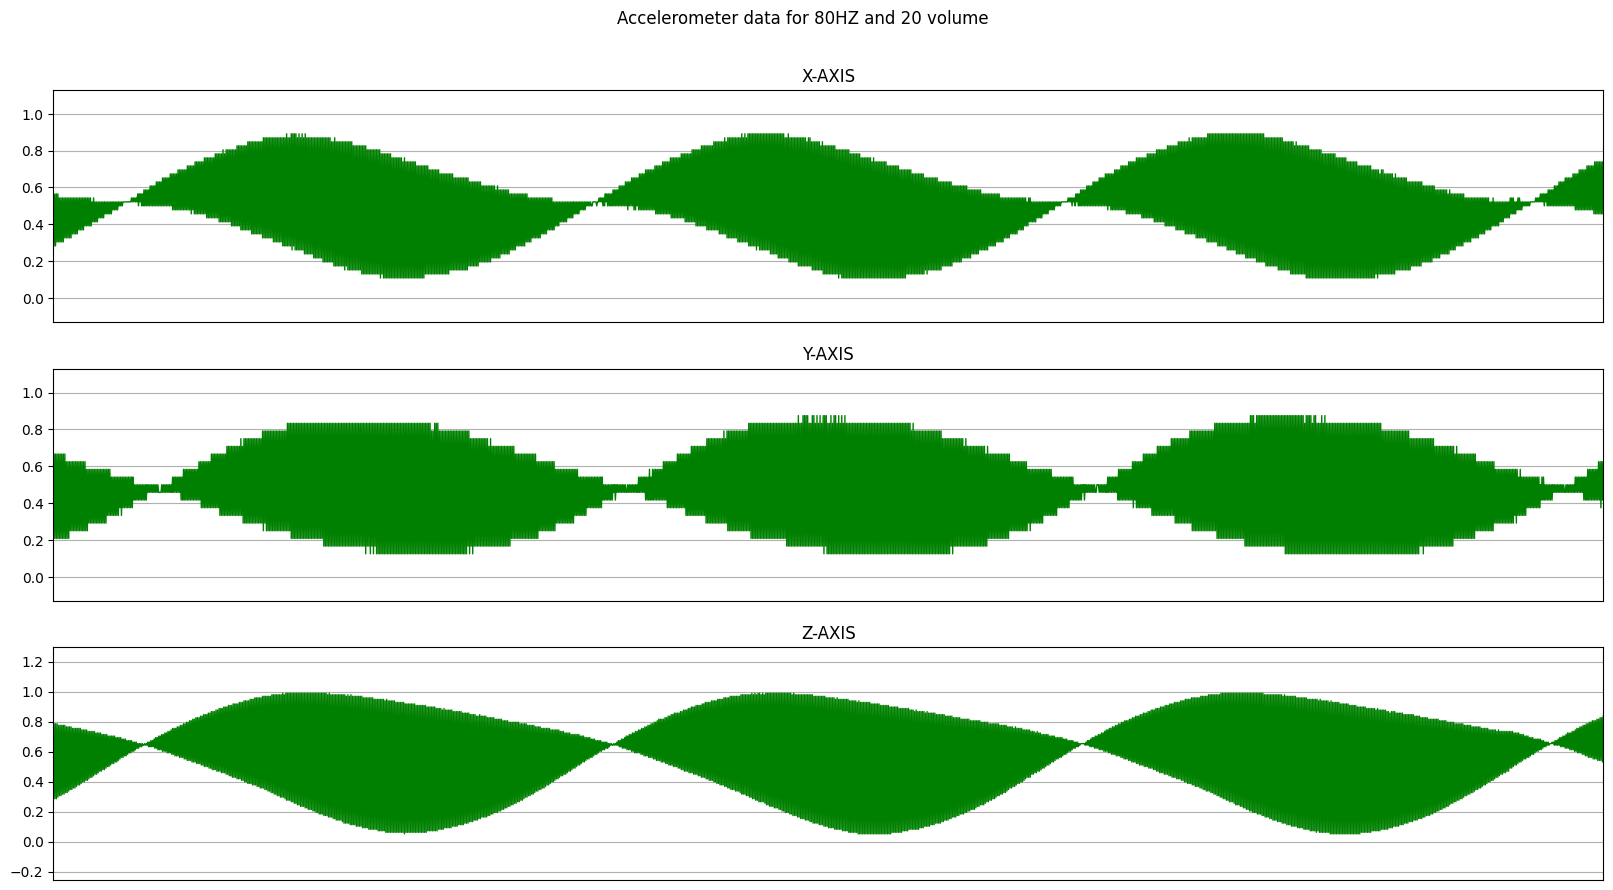

In [16]:
#select a subset of 2000 samples
subset = normalized_train_data_normal[:2000]
plotVibPattern(subset, hertz, volume)

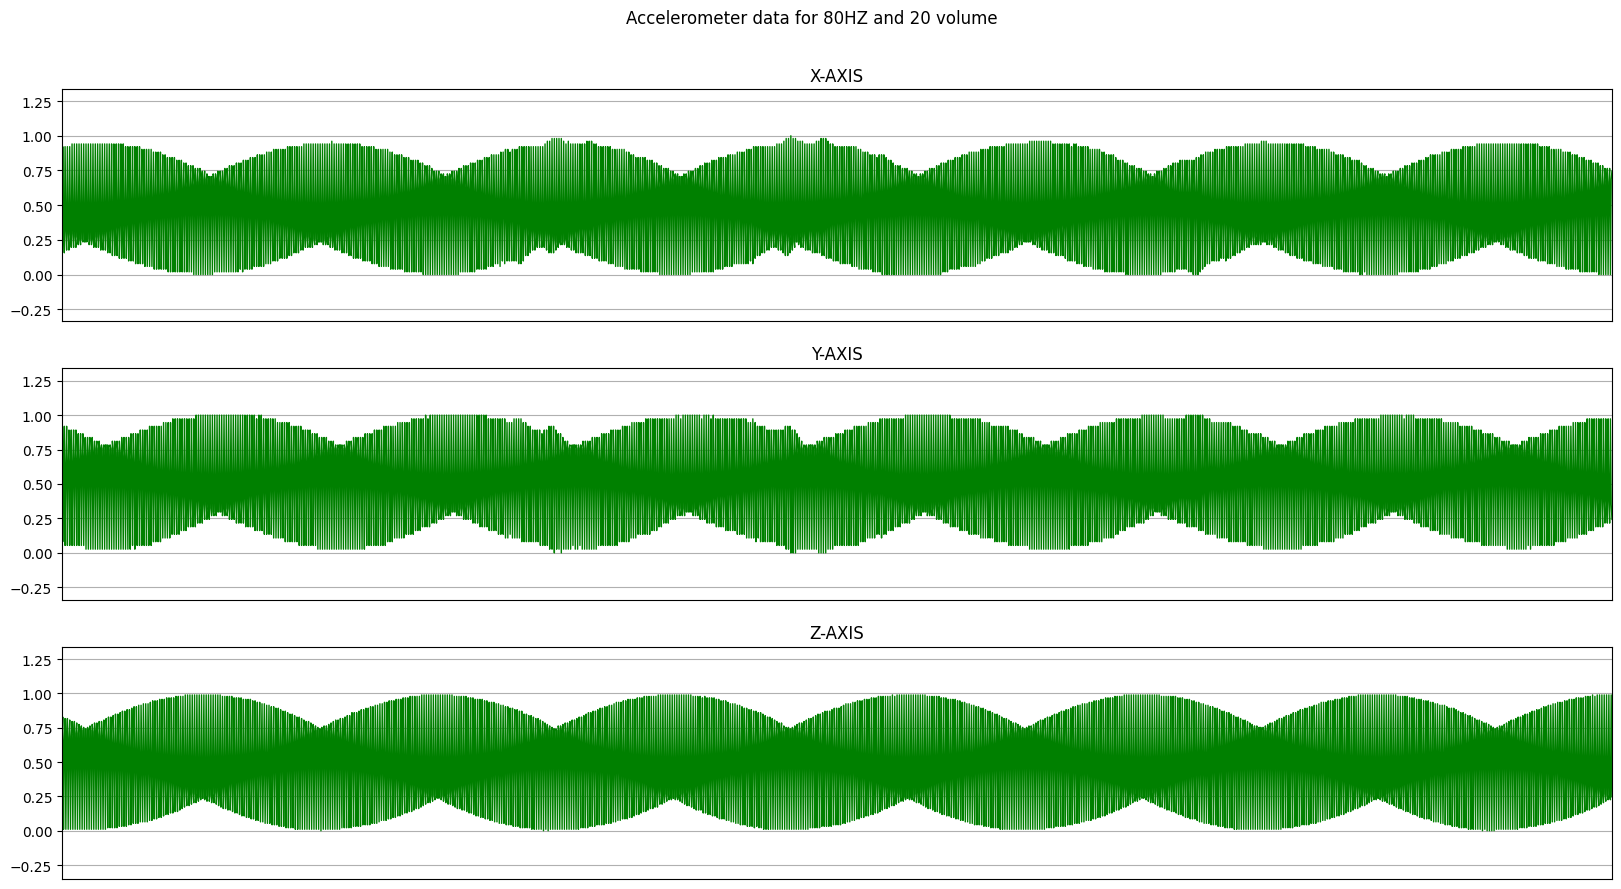

In [17]:
#select a subset of 2000 samples
subset = normalized_train_data_anomalous[:2000]
plotVibPattern(subset, hertz, volume)

As seen in the plot, the behaviour is intact which is exactly what we wanted.

### Feature extraction

Given the application for predictive maintenance based on accelerometer data, some feature extraction techniques that might be relevant include:
- **Frequency Domain Features**: Utilize techniques like Fast Fourier Transform (FFT) to convert time-domain signals to frequency-domain signals. This can help capture information about the vibration frequencies present in the data.
- **Statistical Features**: These might include mean, standard deviation, skewness, kurtosis, etc., which can provide insights into the statistical properties of the data.
- **Time-Domain Features**: Parameters like variance, correlation between different axes, and other moments can be useful.
- **Wavelet Transform**: This can be particularly useful for analyzing non-stationary signals.
- **Energy Features** (emphasis on this): Calculating the energy in different frequency bands.

We will need to experiment with different features and see which ones are most informative for your specific problem.

#### Frequency Domain Features (using FFT):

You can use the Fast Fourier Transform to convert your time-domain signals to the frequency domain. This can capture information about the vibration frequencies present in the data.
You might want to compute the magnitude of the FFT coefficients and consider using the top N frequencies as features.

In [18]:
type(normalized_train_data_normal)

pandas.core.frame.DataFrame

In [19]:
from scipy.fft import fft

def FFT(data):
  def compute_fft_features(x):
      fft_values = fft(x)
      magnitudes = np.abs(fft_values)
      return magnitudes[:5]  # Adjust N as needed

  # Convert DataFrame to numpy array
  norm_numpy_normal = data[['x-axis', 'y-axis', 'z-axis']].to_numpy()

  # Apply FFT to your data
  normalized_data_normal_fft = np.apply_along_axis(compute_fft_features, axis=1, arr=norm_numpy_normal)

  return normalized_data_normal_fft

In [20]:
FFT_train_normal = FFT(normalized_train_data_normal)
FFT_val_normal = FFT(normalized_val_data_normal)
FFT_test_normal = FFT(normalized_test_data_normal)

FFT_train_anomalous = FFT(normalized_train_data_anomalous)
FFT_val_anomalous = FFT(normalized_val_data_anomalous)
FFT_test_anomalous = FFT(normalized_test_data_anomalous)

In [21]:
print(FFT_train_normal.shape)  # Check the shape

# Print some sample values
print(FFT_train_normal[:5])

(25419, 3)
[[1.04906093 0.32848837 0.32848837]
 [1.73498965 0.45540537 0.45540537]
 [1.05926501 0.32517382 0.32517382]
 [1.73498965 0.45540537 0.45540537]
 [1.05926501 0.32517382 0.32517382]]


In [22]:
def plot_fft_results(train_data, val_data, test_data, type):
    plt.figure(figsize=(12, 4))  # Adjust the figure size if needed

    # Plotting Training Data
    plt.subplot(1, 3, 1)
    plt.plot(train_data)
    plt.title('FFT Train Result' + type)
    plt.xlabel('Frequency Component')
    plt.ylabel('Magnitude')

    # Plotting Validation Data
    plt.subplot(1, 3, 2)
    plt.plot(val_data)
    plt.title('FFT Validation Result' + type)
    plt.xlabel('Frequency Component')
    plt.ylabel('Magnitude')

    # Plotting Test Data
    plt.subplot(1, 3, 3)
    plt.plot(test_data)
    plt.title('FFT Test Result' + type)
    plt.xlabel('Frequency Component')
    plt.ylabel('Magnitude')

    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()

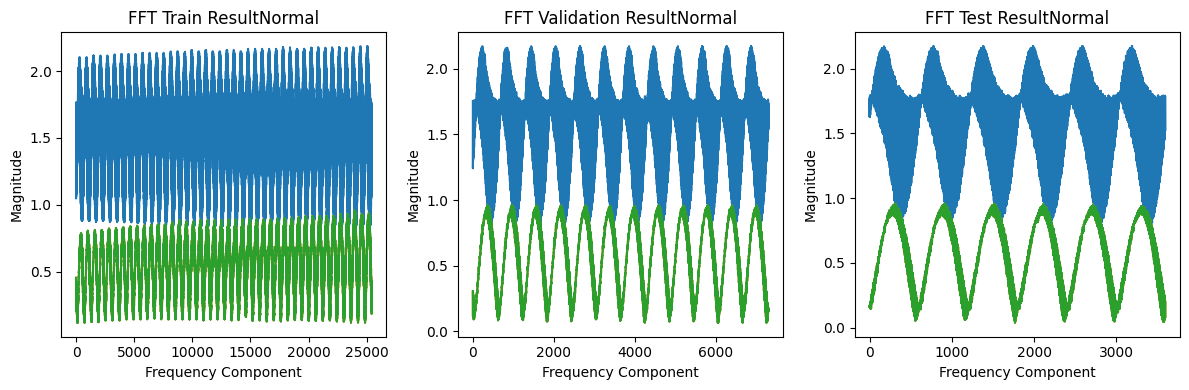

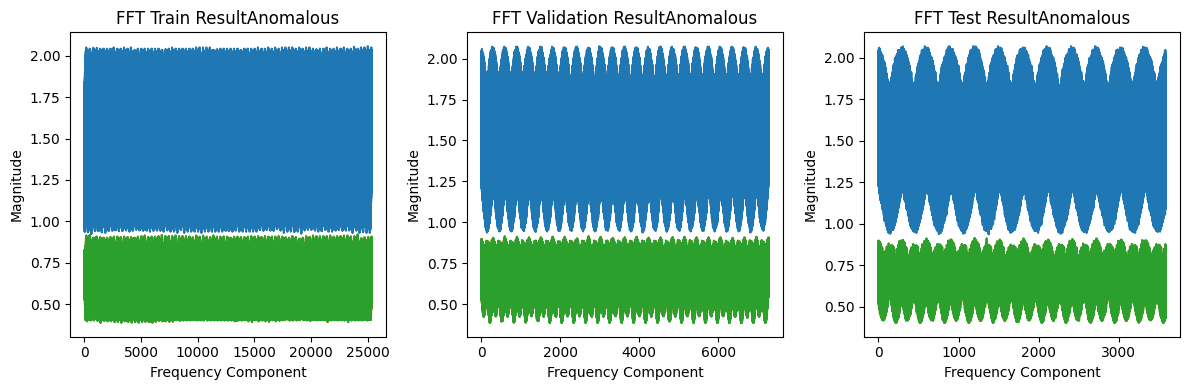

In [23]:
plot_fft_results(FFT_train_normal, FFT_val_normal, FFT_test_normal, "Normal")
plot_fft_results(FFT_train_anomalous, FFT_val_anomalous, FFT_test_anomalous, "Anomalous")

#### Statistical Features:

Compute statistics like mean, standard deviation, skewness, and kurtosis for each axis.

🔑**Note:** Here we need to remove the timestamp as it will also be considered as a sd, mean, etc. and we don't want to have it in this feature extraction method.

In [24]:
# Drop the 'timestamp' column
stat_train_data_normal = normalized_train_data_normal.drop(columns=['timestamp'])
stat_val_data_normal = normalized_val_data_normal.drop(columns=['timestamp'])
stat_test_data_normal = normalized_test_data_normal.drop(columns=['timestamp'])

stats_feat_train_normal = stat_train_data_normal.agg(['mean', 'std', 'skew', 'kurt'])
stats_feat_val_normal = stat_val_data_normal.agg(['mean', 'std', 'skew', 'kurt'])
stats_feat_test_normal = stat_test_data_normal.agg(['mean', 'std', 'skew', 'kurt'])

# Print the results
print("Normal Training Statistical Features:")
print(stats_feat_train_normal)
print("\n")
print("Normal Validation Statistical Features:")
print(stats_feat_val_normal)
print("\n")
print("Normal Testing Statistical Features:")
print(stats_feat_test_normal)

Normal Training Statistical Features:
        x-axis    y-axis    z-axis
mean  0.502789  0.481044  0.580552
std   0.287929  0.309933  0.324933
skew -0.012914  0.072214 -0.364781
kurt -1.189694 -1.485733 -1.307973


Normal Validation Statistical Features:
        x-axis    y-axis    z-axis
mean  0.492414  0.500249  0.576541
std   0.320489  0.333915  0.333589
skew  0.054033  0.030522 -0.379346
kurt -1.239078 -1.482149 -1.288770


Normal Testing Statistical Features:
        x-axis    y-axis    z-axis
mean  0.492887  0.518525  0.580254
std   0.319937  0.326062  0.334099
skew  0.069399 -0.048770 -0.396250
kurt -1.268359 -1.472927 -1.289059


In [25]:
# Drop the 'timestamp' column
stat_train_data_anomalous = normalized_train_data_anomalous.drop(columns=['timestamp'])
stat_val_data_anomalous = normalized_val_data_anomalous.drop(columns=['timestamp'])
stat_test_data_anomalous = normalized_test_data_anomalous.drop(columns=['timestamp'])

stats_feat_train_anomalous = stat_train_data_anomalous.agg(['mean', 'std', 'skew', 'kurt'])
stats_feat_val_anomalous = stat_val_data_anomalous.agg(['mean', 'std', 'skew', 'kurt'])
stats_feat_test_anomalous = stat_test_data_anomalous.agg(['mean', 'std', 'skew', 'kurt'])

# Print the results
print("Normal Training Statistical Features:")
print(stats_feat_train_anomalous)
print("\n")
print("Normal Validation Statistical Features:")
print(stats_feat_val_anomalous)
print("\n")
print("Normal Testing Statistical Features:")
print(stats_feat_test_anomalous)

Normal Training Statistical Features:
        x-axis    y-axis    z-axis
mean  0.474203  0.528936  0.493765
std   0.334817  0.339582  0.351547
skew  0.008814 -0.057132  0.013149
kurt -1.506504 -1.495834 -1.518229


Normal Validation Statistical Features:
        x-axis    y-axis    z-axis
mean  0.503681  0.516526  0.493680
std   0.355608  0.347786  0.351610
skew  0.001666 -0.048415  0.011440
kurt -1.512028 -1.494901 -1.516575


Normal Testing Statistical Features:
        x-axis    y-axis    z-axis
mean  0.493484  0.516375  0.499282
std   0.348132  0.348448  0.354784
skew  0.012162 -0.058448  0.004338
kurt -1.510428 -1.492412 -1.516744


#### Time-Domain Features:

These might include parameters like variance, correlation between different axes, and other moments.

In [36]:
def time_domain(data, type, data_type):
  data = data.drop(columns=['timestamp'])

  # Calculate Variance
  variance = np.var(data, axis=0)

  # Calculate Correlation Matrix
  correlation_matrix = np.corrcoef(data, rowvar=False)

  # Print the results
  print("\nVariance " + type + " " + data_type + ":")
  print(variance)
  print("\nCorrelation Matrix "  + type + " " + data_type + ":")
  print(correlation_matrix)
  print("\n")
  return variance, correlation_matrix

In [37]:
TD_train_normal = time_domain(normalized_train_data_normal, "Normal", "Train")
TD_val_normal = time_domain(normalized_val_data_normal, "Normal", "Validation")
TD_test_normal = time_domain(normalized_test_data_normal, "Normal", "Test")


Variance Normal Train:
x-axis    0.082900
y-axis    0.096055
z-axis    0.105577
dtype: float64

Correlation Matrix Normal Train:
[[ 1.         -0.92061632 -0.84286026]
 [-0.92061632  1.          0.96928166]
 [-0.84286026  0.96928166  1.        ]]



Variance Normal Validation:
x-axis    0.102699
y-axis    0.111484
z-axis    0.111266
dtype: float64

Correlation Matrix Normal Validation:
[[ 1.         -0.93196615 -0.85748624]
 [-0.93196615  1.          0.97407209]
 [-0.85748624  0.97407209  1.        ]]



Variance Normal Test:
x-axis    0.102331
y-axis    0.106287
z-axis    0.111591
dtype: float64

Correlation Matrix Normal Test:
[[ 1.         -0.92294174 -0.86390935]
 [-0.92294174  1.          0.98176591]
 [-0.86390935  0.98176591  1.        ]]




In [38]:
TD_train_anomalous = time_domain(normalized_train_data_anomalous, "Anomalous", "Train")
TD_val_anomalous = time_domain(normalized_val_data_anomalous, "Anomalous", "Validation")
TD_test_anomalous = time_domain(normalized_test_data_anomalous, "Anomalous", "Test")


Variance Anomalous Train:
x-axis    0.112098
y-axis    0.115312
z-axis    0.123580
dtype: float64

Correlation Matrix Anomalous Train:
[[ 1.         -0.99352099  0.46938895]
 [-0.99352099  1.         -0.37665384]
 [ 0.46938895 -0.37665384  1.        ]]



Variance Anomalous Validation:
x-axis    0.126440
y-axis    0.120938
z-axis    0.123613
dtype: float64

Correlation Matrix Anomalous Validation:
[[ 1.         -0.99398932  0.46131926]
 [-0.99398932  1.         -0.37184264]
 [ 0.46131926 -0.37184264  1.        ]]



Variance Anomalous Test:
x-axis    0.121162
y-axis    0.121382
z-axis    0.125836
dtype: float64

Correlation Matrix Anomalous Test:
[[ 1.         -0.99404011  0.46027877]
 [-0.99404011  1.         -0.37128827]
 [ 0.46027877 -0.37128827  1.        ]]




#### Energy Features:

Calculate the energy in different frequency bands.

In [53]:
def energy_features(train, validation, test, type):
  train = train.drop(columns=['timestamp'])
  validation = validation.drop(columns=['timestamp'])
  test = test.drop(columns=['timestamp'])

  def compute_energy(x):
      return np.sum(x**2)

  energy_train = train.apply(compute_energy, axis=1)
  energy_validation = validation.apply(compute_energy, axis=1)
  energy_test = test.apply(compute_energy, axis=1)

  plt.figure(figsize=(12, 4))  # Adjust the figure size if needed

  # Plotting Training Data
  plt.subplot(1, 3, 1)
  plt.plot(energy_train)
  plt.title('Energy Train Result' + type)
  plt.xlabel('Time Segment')
  plt.ylabel('Energy')

  # Plotting Validation Data
  plt.subplot(1, 3, 2)
  plt.plot(energy_validation)
  plt.title('Energy Validation Result' + type)
  plt.xlabel('Time Segment')
  plt.ylabel('Energy')

  # Plotting Test Data
  plt.subplot(1, 3, 3)
  plt.plot(energy_test)
  plt.title('Energy Test Result' + type)
  plt.xlabel('Time Segment')
  plt.ylabel('Energy')

  plt.tight_layout()  # Ensure proper spacing between subplots
  plt.show()

  return energy_train, energy_validation, energy_test



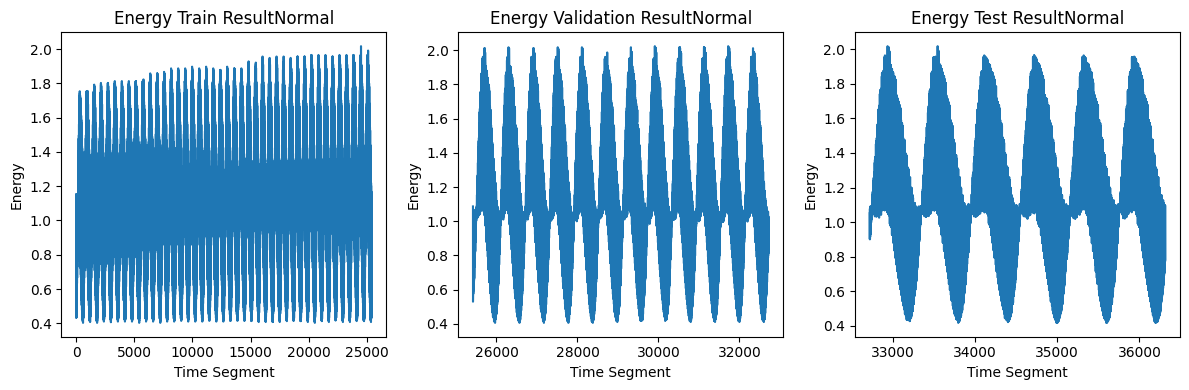

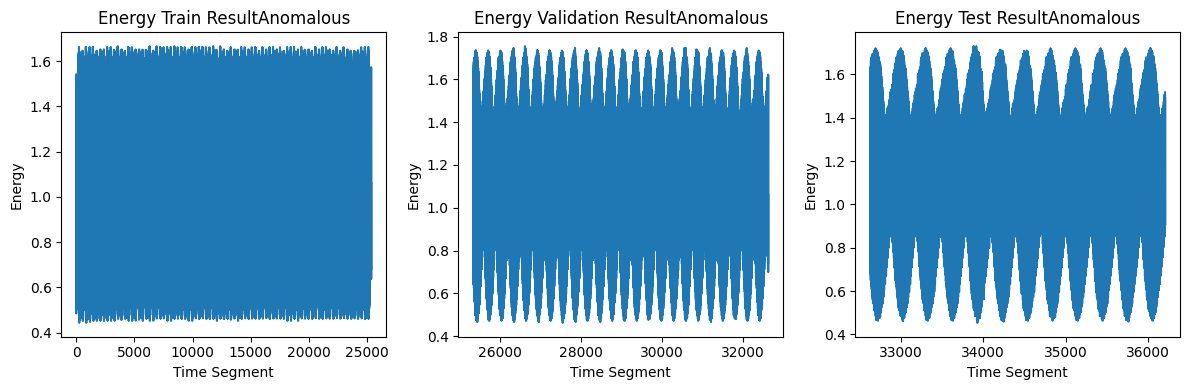

In [54]:
[energy_train_normal, energy_validation_normal, energy_test_normal] = energy_features(normalized_train_data_normal, normalized_val_data_normal, normalized_test_data_normal, "Normal")
[energy_train_anomalous, energy_validation_anomalous, energy_test_anomalous] = energy_features(normalized_train_data_anomalous, normalized_val_data_anomalous, normalized_test_data_anomalous, "Anomalous")

Remark: It's identical to the FFT graphs (TODO: add some explanation as to why or debug if it turns out to be the wrong implementation)

#### Wavelet Transform:

This can be particularly useful for analyzing non-stationary signals.

In [76]:
import pywt

def wavelet_feat(train, validation, test, type):

  def compute_wavelet_features(x):
      coeffs = pywt.wavedec(x, 'haar', level=1)  # Adjust wavelet type and level as needed
      return np.concatenate(coeffs)


  wavelet_train = train.apply(compute_wavelet_features, axis=1)
  wavelet_validation = validation.apply(compute_wavelet_features, axis=1)
  wavelet_test = test.apply(compute_wavelet_features, axis=1)


  def plot_wavelet_results(wavelet_features, id, type, data):

    plt.subplot(1, 3, id)
    for i, row_wavelet_features in enumerate(wavelet_features):
        plt.plot(row_wavelet_features, label=f'Row {i+1}')

    plt.title('Wavelet Transform Results' + data + type)
    plt.xlabel('Position in Signal')
    plt.ylabel('Coefficient Value')
    plt.show()


  plt.figure(figsize=(12, 4))  # Adjust the figure size if needed

  plot_wavelet_results(wavelet_train, 1, type, "Train")
  plot_wavelet_results(wavelet_validation, 2, type, "Validation")
  plot_wavelet_results(wavelet_test, 3, type, "Test")

  plt.tight_layout()  # Ensure proper spacing between subplots
  plt.show()

  return wavelet_train, wavelet_validation, wavelet_test

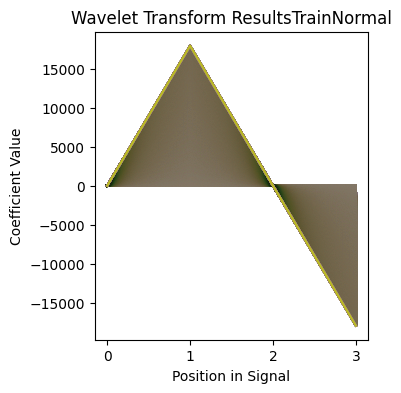

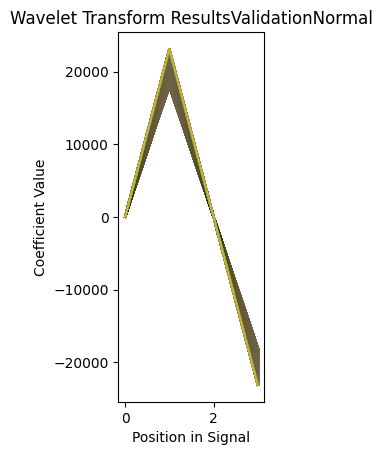

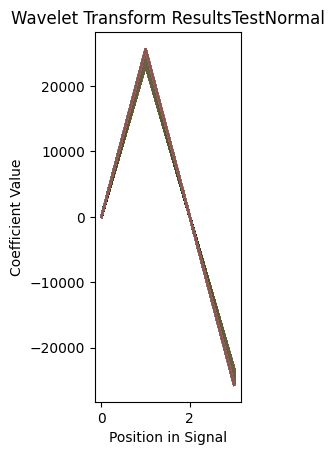

<Figure size 640x480 with 0 Axes>

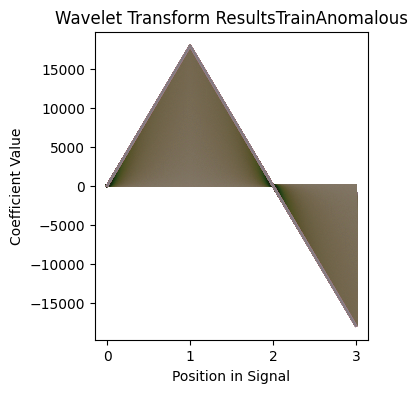

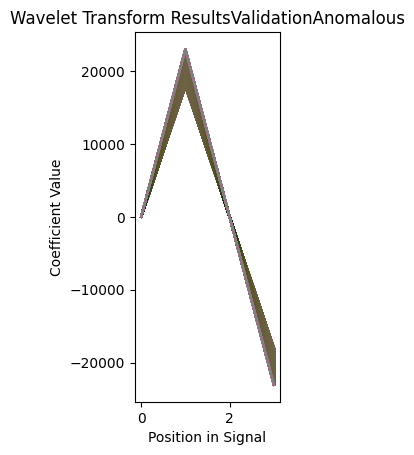

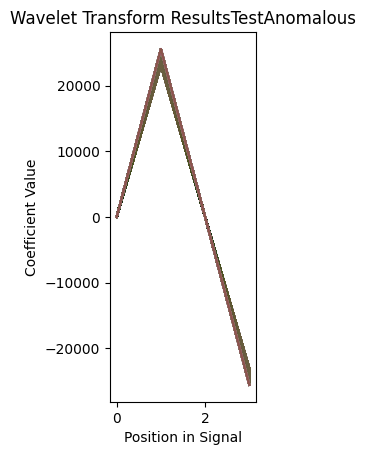

<Figure size 640x480 with 0 Axes>

ValueError: ignored

In [79]:
# Call the function and unpack the results
wave_results_normal = wavelet_feat(normalized_train_data_normal, normalized_val_data_normal, normalized_test_data_normal, "Normal")
wave_results_anomalous = wavelet_feat(normalized_train_data_anomalous, normalized_val_data_anomalous, normalized_test_data_anomalous, "Anomalous")

# Unpack the results
[wave_train_normal, wave_validation_normal, wave_test_normal] = wave_results_normal
[wave_train_anomalous, wave_validation_anomalous, wave_test_anomalous] = wave_results_anomalous

It's important to continue with the process by combining these features into a feature matrix and proceeding with model training and evaluation. Additionally, it's recommended to visualize and explore the features further to gain deeper insights.

# TODO

In [ ]:
# Assuming you have computed features for both normal and anomalous data
# Replace the placeholders below with your actual feature data

# Combine features for normal data
normal_combined_features = np.hstack((normalized_data_normal_fft, statistical_features, time_features, energy_features, wavelet_features))
#anomalous_combined_features = np.hstack((fft_anomalous, statistical_anomalous, time_anomalous, energy_anomalous, wavelet_anomalous))

# Create labels for normal (0) and anomalous (1) data
normal_labels = np.zeros((normal_combined_features.shape[0], 1))  # 0 for normal
#anomalous_labels = np.ones((anomalous_combined_features.shape[0], 1))  # 1 for anomalous

"""
# Combine the features and labels
combined_features = np.vstack((normal_combined_features, anomalous_combined_features))
combined_labels = np.vstack((normal_labels, anomalous_labels))

# Shuffle the data (if needed)
shuffle_indices = np.random.permutation(combined_features.shape[0])
combined_features = combined_features[shuffle_indices]
combined_labels = combined_labels[shuffle_indices]
"""

shuffle_indices = np.random.permutation(normal_combined_features.shape[0])
combined_features = normal_combined_features[shuffle_indices]
combined_labels = normal_labels[shuffle_indices]

# Now, 'combined_features' contains all your features, and 'combined_labels' contains the corresponding labels

## Train the model

For **autoencoders**, decide on the architecture (number of layers, units per layer, activation functions, etc.). Also, choose an appropriate loss function (e.g., mean squared error for reconstruction tasks). For **classification**, experiment with different algorithms (e.g., Random Forest, SVM, Neural Networks) and evaluate their performance.
For **K-means**, you'll need to determine the optimal number of clusters based on your data.

- Choose model architecture (autoencoders, classification, K-means)
- compile (choose hyperparameters)
- fit
- evaluate

Model Interpretability: Depending on your application, it might be important to understand which features or patterns the model is using to make predictions.

### Choose model architecture

### Compile

Hyperparameter Tuning: Experiment with different hyperparameters to improve the model's performance. Techniques like cross-validation can help in this regard.

### Fit

Hyperparameter Tuning: Experiment with different hyperparameters to improve the model's performance. Techniques like cross-validation can help in this regard.

### Evaluate

Model Evaluation: Use appropriate evaluation metrics to assess the performance of your models. This might include accuracy, precision, recall, F1-score, or others depending on the problem.

## Deploying the model

Ensure that the microcontroller has enough computational resources (memory, processing power) to handle the chosen model. You may need to optimize or simplify the model depending on the constraints.

- quantize
- convert to .tflite
- continue in Arduino IDE to write the script

### Quantize

### Convert to .tflite

### Moving to Arduino